Saved: resultPic/exp4/exp4_N1_pointwise_bars.pdf


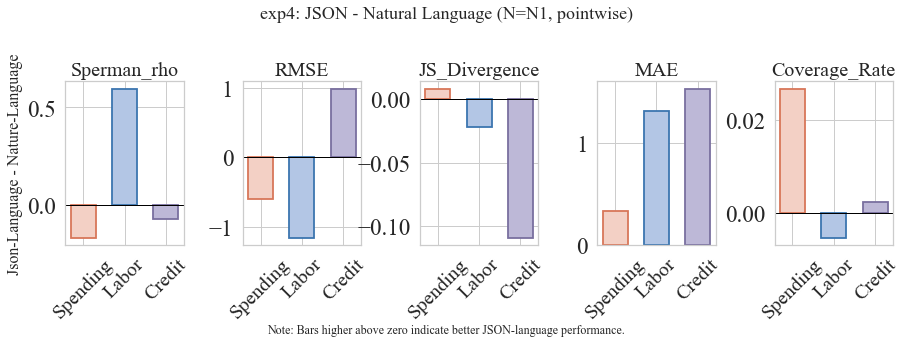

In [5]:
import json
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1) 读取 exp4
root = Path("exp4")
rows = []

for f in root.rglob("*.json"):
    model = f.parent.name
    n = f.parent.parent.name
    kind = "pointwise" if "pointwise" in f.name else "distribution"
    data = json.loads(f.read_text(encoding="utf-8"))
    for domain, metrics in data.items():
        row = {"N": n, "kind": kind, "model": model, "domain": domain}
        row.update(metrics)
        rows.append(row)

df = pd.DataFrame(rows)

# 1.5) N1 pointwise + N50 (mae, coverage_rate)
sub_n1 = df[(df["N"]=="N1") & (df["kind"]=="pointwise")].copy()
sub_n50 = df[(df["N"]=="N50") & (df["kind"]=="distribution")].copy()

sub = sub_n1.copy()
n50_metrics = [m for m in ["mae", "coverage_rate"] if m in df.columns]
if n50_metrics:
    cols = ["domain", "model"] + n50_metrics
    n50_vals = sub_n50[cols].dropna()
    sub = sub.drop(columns=n50_metrics, errors="ignore")
    sub = sub.merge(n50_vals, on=["domain", "model"], how="left")

# 2) 指定 JSON vs 自然语言模型名（必要时手动改这里）
model_json = "Json-Language"
model_nl = "Nature-Language"
models = sorted(df["model"].dropna().unique())
if model_json not in models or model_nl not in models:
    raise ValueError(f"模型名不匹配: {models}, 请修改 model_json/model_nl")

# 3) 指标（固定 5 个，coverage_rate 预留位置）
#metrics = ["spearman_rho", "js_divergence", "rmse", "mae", "coverage_rate"]
metrics = ["spearman_rho", "rmse", "js_divergence", "mae", "coverage_rate"]
domain_label_map = {"spending": "Spending", "labor": "Labor", "credit": "Credit"}
domain_color_map = {
    "spending": {"face": "#F3D0C5", "edge": "#D87659"},
    "labor": {"face": "#B3C6E5", "edge": "#3B75AF"},
    "credit": {"face": "#BDB8D7", "edge": "#796F9F"},
}

metric_label_map = {
    "spearman_rho": "Sperman_rho",
    "js_divergence": "JS_Divergence",
    "rmse": "RMSE",
    "mae": "MAE",
    "coverage_rate": "Coverage_Rate",
}

def format_domain(d: str) -> str:
    return domain_label_map.get(d, d.title())

def format_metric(m: str) -> str:
    return metric_label_map.get(m, m)

# 4) 计算 delta = JSON - 自然语言（正负都有，统一方向为：正值=JSON更好）
rows_delta = []
for (n, kind, domain), g in sub.groupby(["N", "kind", "domain"], dropna=False):
    row = {"N": n, "kind": kind, "domain": domain}
    for m in metrics:
        if m not in sub.columns:
            continue
        tmp = g[["model", m]].dropna()
        if model_json not in tmp["model"].values or model_nl not in tmp["model"].values:
            continue
        j = tmp.loc[tmp["model"] == model_json, m].iloc[0]
        nl = tmp.loc[tmp["model"] == model_nl, m].iloc[0]
        row[m] = j - nl
    rows_delta.append(row)

delta_df = pd.DataFrame(rows_delta)

# 5) 展平并补全所有 (domain, metric) 组合，coverage_rate 也预留
base = sub[["N", "kind", "domain"]].drop_duplicates()
grid = base.assign(key=1).merge(pd.DataFrame({"metric": metrics, "key": 1}), on="key").drop(columns="key")
plot_long = delta_df.melt(
    id_vars=["N", "kind", "domain"],
    value_vars=[m for m in metrics if m in delta_df.columns],
    var_name="metric",
    value_name="delta"
)
plot_long = grid.merge(plot_long, on=["N", "kind", "domain", "metric"], how="left")

# 6) 子图：每个指标一个小图（每图 3 个领域柱子）
sns.set_theme(
    style="whitegrid",
    font="Times New Roman",
    rc={
        "font.size": 16,
        "axes.titlesize": 20,
        "axes.labelsize": 16,
        "xtick.labelsize": 20,
        "ytick.labelsize": 23,
        "legend.fontsize": 18,
        "figure.titlesize": 18,
    },
)
for (n, kind), sub in plot_long.groupby(["N", "kind"], dropna=False):
    sub = sub.copy()
    sub["metric"] = pd.Categorical(sub["metric"], categories=metrics, ordered=True)
    domain_order = [d for d in ["spending", "labor", "credit"] if d in sub["domain"].unique()]
    if not domain_order:
        domain_order = sorted(sub["domain"].dropna().unique())
    domain_display_order = [format_domain(d) for d in domain_order]

    fig, axes = plt.subplots(1, len(metrics), figsize=(2.4 * len(metrics) + 1.0, 4.5), sharey=False)
    if len(metrics) == 1:
        axes = [axes]

    for ax, m in zip(axes, metrics):
        plot_sub = sub[sub["metric"] == m].copy()
        plot_sub["domain"] = pd.Categorical(plot_sub["domain"], categories=domain_order, ordered=True)
        plot_sub = plot_sub.sort_values("domain")
        plot_sub["domain_display"] = plot_sub["domain"].map(format_domain)

        if plot_sub["delta"].notna().sum() == 0:
            # 预留 coverage_rate 或缺失指标的位置
            ax.axhline(0, color="black", linewidth=1)
            ax.set_title(format_metric(m))
            ax.set_xticks(range(len(domain_display_order)))
            ax.set_xticklabels(domain_display_order, rotation=35, ha="right")
            ax.text(0.5, 0.5, "pending", transform=ax.transAxes,
                    ha="center", va="center", color="gray")
        else:
            x = np.arange(len(plot_sub["domain_display"]))
            for xi, (d_raw, d_disp, v) in enumerate(zip(plot_sub["domain"], plot_sub["domain_display"], plot_sub["delta"])):
                colors = domain_color_map.get(d_raw, {"face": "#cccccc", "edge": "#666666"})
                ax.bar(xi, v, width=0.6, color=colors["face"], edgecolor=colors["edge"], linewidth=1.8)
            ax.set_xticks(x)
            ax.set_xticklabels(plot_sub["domain_display"].tolist(), rotation=35, ha="right")
            ax.axhline(0, color="black", linewidth=1)
            ax.set_title(format_metric(m))

        ax.set_xlabel("")
        ax.tick_params(axis="x", rotation=45)
        for label in ax.get_xticklabels():
            label.set_ha("center")

        if ax == axes[0]:
            ax.set_ylabel(f"{model_json} - {model_nl}")
        else:
            ax.set_ylabel("")

    fig.suptitle(f"exp4: JSON - Natural Language (N={n}, {kind})", y=1.02, fontsize=18)
    fig.text(0.5, 0.01, "Note: Bars higher above zero indicate better JSON-language performance.", ha="center", fontsize=12)
    plt.tight_layout(pad=1, w_pad=1)
    fig.subplots_adjust(wspace=0.5)

    # 保存到 resultPic/exp4/exp4_{N}_{kind}_bars.pdf
    out_dir = Path("resultPic") / root.name
    out_dir.mkdir(parents=True, exist_ok=True)
    safe_kind = str(kind).replace("/", "_")
    out_path = out_dir / f"{root.name}_{n}_{safe_kind}_bars.pdf"
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    print("Saved:", out_path)

    plt.show()


In [34]:
import json
from pathlib import Path
import pandas as pd

root = Path("exp4")
rows = []

for f in root.rglob("*.json"):
    # 目录结构: exp2/exp2/N?/model/metrics_*.json
    model = f.parent.name
    n = f.parent.parent.name
    kind = "pointwise" if "pointwise" in f.name else "distribution"

    data = json.loads(f.read_text(encoding="utf-8"))
    for domain, metrics in data.items():
        row = {
            "N": n,
            "model": model,
            "kind": kind,
            "domain": domain,
        }
        row.update(metrics)
        rows.append(row)

df = pd.DataFrame(rows)
display(df)


,N,model,kind,domain,spearman_rho,spearman_p,js_divergence,rmse,mae,n_samples,n_time_points,cleaning_stats,coverage_rate
0,N1,Nature-Language,pointwise,spending,0.1470,0.493193,0.3423,3.1682,2.30,18526,24.0,"{'original_rows': 26579, 'human_null': 49, 'll...",NaN
1,N1,Nature-Language,pointwise,labor,-0.4609,0.023418,0.4723,62.9590,55.36,16476,24.0,"{'original_rows': 26803, 'human_null': 10327, ...",NaN
2,N1,Nature-Language,pointwise,credit,0.0038,0.985442,0.3088,22.1839,14.55,27125,25.0,"{'original_rows': 27251, 'human_null': 126, 'l...",NaN
3,N1,Json-Language,pointwise,spending,NaN,NaN,0.4550,3.1656,2.30,14384,24.0,"{'original_rows': 26579, 'human_null': 49, 'll...",NaN
4,N1,Json-Language,pointwise,labor,0.1357,0.527379,0.4506,61.8031,53.65,16476,24.0,"{'original_rows': 26803, 'human_null': 10327, ...",NaN
5,N1,Json-Language,pointwise,credit,-0.0669,0.750606,0.1996,23.1693,13.95,27125,25.0,"{'original_rows': 27251, 'human_null': 126, 'l...",NaN
6,N50,Nature-Language,distribution,spending,NaN,NaN,NaN,NaN,2.45,1941,NaN,"{'original_rows': 2657, 'human_null': 2, 'llm_...",0.2092
7,N50,Nature-Language,distribution,labor,NaN,NaN,NaN,NaN,41.38,1633,NaN,"{'original_rows': 2680, 'human_null': 1047, 'l...",0.0508
8,N50,Nature-Language,distribution,credit,NaN,NaN,NaN,NaN,15.19,2715,NaN,"{'original_rows': 2724, 'human_null': 9, 'llm_...",0.0785
9,N50,Json-Language,distribution,spending,NaN,NaN,NaN,NaN,2.94,2157,NaN,"{'original_rows': 2657, 'human_null': 2, 'llm_...",0.2434
